<a href="https://colab.research.google.com/github/BillXu21/culvert-identification/blob/main/Curv_CNN2_Train_(97.9%25).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from skimage import io
import glob

from sklearn.model_selection import train_test_split
# import tensorflow as tf

import tensorflow as tf

import numpy as np
import pandas as pd


#from tensorflow.keras.callbacks import TensorBoard
from tensorflow.compat.v1.keras.models import Sequential
from tensorflow.compat.v1.keras.layers import BatchNormalization
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.compat.v1.keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from tensorflow.compat.v1.keras.optimizers import Adadelta, Adam
from tensorflow.compat.v1.keras.callbacks import ModelCheckpoint
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler

#from tensorflow.keras import callbacks
import matplotlib.pyplot as plt

tf.compat.v1.disable_eager_execution()

In [ ]:
path='/content/drive/MyDrive/WFBBDEM/'   #DEM

# using one watershed to train model, 3 of them to test
pathTrain='WFBBDEM_Train/'
pathTest1='WFBBDEM_Test/'

In [ ]:
import pickle
with open('/content/drive/MyDrive/WFBBDEM/WFBBDEM+/NEWFBB_DEM/Cuvature/data','rb') as fin: data = pickle.load(fin)
with open('/content/drive/MyDrive/WFBBDEM/WFBBDEM+/NEWFBB_DEM/Cuvature/label',  'rb') as fin: label = pickle.load(fin)
with open('/content/drive/MyDrive/WFBBDEM/WFBBDEM+/NEWFBB_DEM/Cuvature/name','rb') as fin: name = pickle.load(fin)

In [ ]:
data=np.expand_dims(data,3) # add channel dimension, 4D

labelN=label.shape[0]


label_name=np.empty((labelN,2),dtype=int) # label + name
for i in range(labelN):
    label_name[i,0]=label[i] # label
    if (name[i].isdigit()):
        name[i]=name[i]
    else:
        name[i]=name[i][1:] # only keep number, delete first letter
    name[i] = name[i].split()[0]
    label_name[i,1]=name[i]

In [ ]:
# split data into train and test groups
train_data,test_data,train_label,test_label = train_test_split(data,label_name,test_size=0.2,stratify=label)

In [ ]:
# creat CNN model
def createCNN():
    inputs = [keras.layers.Input(shape = (100,100,1)) for i in range(5)]
    merged = keras.layers.Input(shape = (100,100,1))
    a = Convolution2D(128,3,3,padding='same')(merged)
    b = BatchNormalization()(a)
    c = Activation('relu')(b)
    d = Dropout(0.3)(c)

    e = Convolution2D(256,3,3,padding='same')(d)
    f = BatchNormalization()(e)
    g = Activation('relu')(f)
    h = Dropout(0.3)(g)

    i = Convolution2D(512,3,3,padding='same')(h)
    j = BatchNormalization()(i)
    k = Activation('relu')(j)
    l = Dropout(0.3)(k)

    flat = Flatten()(l)

    m = Dense(512,activation = 'relu')(flat)
    n = Dropout(0.5)(m)
    o = Dense(128,activation = 'relu')(n)
    p = Dropout(0.5)(o)
    q = Dense(32,activation = 'relu')(p)
    r = Dropout(0.5)(q)
    s = Dense(2,activation = 'softmax')(r)

    model = keras.models.Model(inputs = merged, outputs = s)

    # model.summary()

    return model

In [ ]:
LEARNING_RATE = 1e-30
BATCH_SIZE = 64
EPOCHS = 20


model = createCNN()

model.load_weights('/content/drive/MyDrive/WFBBDEM/Models/ModelCURV2022CNN.h5')

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
#model.summary()

In [ ]:
import gc
gc.collect()

9707

In [ ]:
OUT_DIR = "/content/drive/MyDrive/WFBBDEM/Models"
checkpoint = ModelCheckpoint(os.path.join(OUT_DIR, 'ModelCURV2022CNN1.h5'),  # model filename
                              monitor='val_accuracy', # quantity to monitor
                              verbose=1, # verbosity - 0 or 1
                              save_best_only= True, # The latest best model will not be overwritten
                              save_weights_only=True, # save model, not only weights
                              mode='auto') # The decision to overwrite model is made
                                            # automatically depending on the quantity to monitor

model_details = model.fit(train_data, train_label[:,0],
                          batch_size = BATCH_SIZE,
                          epochs = EPOCHS,
                          validation_split=0.2,
                          callbacks=[checkpoint],
                          verbose=1)


Train on 2588 samples, validate on 647 samples
Epoch 1/20
2560/2588 [============================>.] - ETA: 0s - loss: 0.1787 - accuracy: 0.9316

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_accuracy improved from -inf to 0.97218, saving model to /content/drive/MyDrive/WFBBDEM/Models/ModelCURV2022CNN1.h5
2588/2588 [==============================] - 5s 2ms/sample - loss: 0.1782 - accuracy: 0.9316 - val_loss: 0.0882 - val_accuracy: 0.9722
Epoch 2/20
2588/2588 [==============================] - ETA: 0s - loss: 0.1820 - accuracy: 0.9374
Epoch 2: val_accuracy did not improve from 0.97218
2588/2588 [==============================] - 2s 753us/sample - loss: 0.1820 - accuracy: 0.9374 - val_loss: 0.0906 - val_accuracy: 0.9722
Epoch 3/20
2588/2588 [==============================] - ETA: 0s - loss: 0.1815 - accuracy: 0.9328
Epoch 3: val_accuracy did not improve from 0.97218
2588/2588 [==============================] - 2s 745us/sample - loss: 0.1815 - accuracy: 0.9328 - val_loss: 0.0917 - val_accuracy: 0.9706
Epoch 4/20
2560/2588 [============================>.] - ETA: 0s - loss: 0.1722 - accuracy: 0.9344
Epoch 4: val_accuracy did not improve from 0.97218
2588/2588 [====

In [ ]:
#### plot confusion matrix
def plot_confusion_matrix(confusion_mat):
    plt.imshow(confusion_mat,interpolation='nearest',cmap=plt.cm.Wistia)
    plt.title('CNN Confusion Matrix',fontsize=20)
    plt.colorbar()
    tick_marks=np.arange(2) # class number
    plt.xticks(tick_marks,tick_marks,fontsize=16)
    plt.yticks(tick_marks,tick_marks,fontsize=16)
    plt.ylabel('True Label',fontsize=16)
    plt.xlabel('Predicted Label',fontsize=16)
    for i in range(len(confusion_mat)):    #row
        for j in range(len(confusion_mat[i])):    #col
            plt.text(j, i, confusion_mat[i][j],fontsize=16) # images number of each part
    plt.show()

<ipython-input-118-e555ec3cf5ee>:4: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df=pd.DataFrame(history.history,index=np.arange(0, EPOCHS).astype(dtype=np.str))


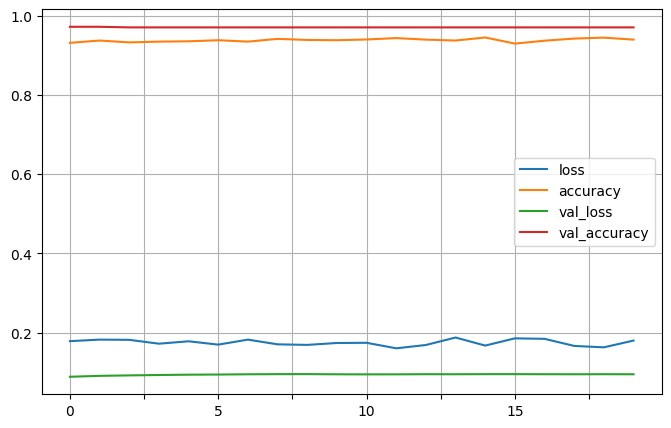

In [ ]:
######################### learning curve

def plot_learning_curves(history):
    df=pd.DataFrame(history.history,index=np.arange(0, EPOCHS).astype(dtype=np.str))
    df.plot(use_index=True,figsize=(8, 5))
    plt.grid(True)

    #plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(model_details)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


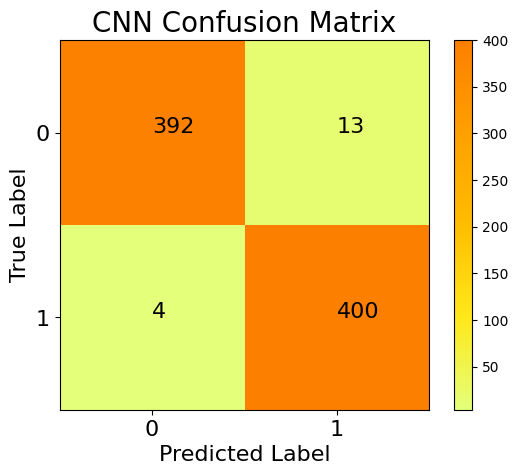

Accuracy: 0.9790 Loss: 0.0890 Precision: 0.9792109961601487 Recall: 0.9790001222344457 F1: 0.9791055478431046 Batch Size: 64 Learning Rate: 1e-30 Epochs: 20


In [ ]:
# Predict
scroe, accuracy = model.evaluate(test_data, test_label[:,0], batch_size=BATCH_SIZE)
pred_label = model.predict(test_data)
#pred_label = [sum([i[0] for i in q]) for q in test_data]
pred_label = np.argmax(pred_label, axis=1)


for t in range(pred_label.shape[0]):
    NameWrong=[]
    labelPred=[]
    if (pred_label[t]!=test_label[t,0]):
        # print (test_label[t,0], test_label[t,1], pred_label[t])
        NameWrong.append(test_label[t,1])
        labelPred.append(pred_label[t])
confusion_matrix = tf.math.confusion_matrix(labels=test_label[:,0],predictions=pred_label, num_classes=2, dtype=tf.int32, name=None, weights=None)
sess=tf.compat.v1.Session()

#with tf.compat.v1.Session(graph=g) as sess:
confusion_matrix = sess.run(confusion_matrix)
plot_confusion_matrix(confusion_matrix)

#plot_learning_curves(model_details)
precision = (confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[1][0])+confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[0][1]))/2
recall = (confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[0][1])+confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[1][0]))/2
F = 2*(precision*recall)/(precision+recall)
print ('Accuracy:', '{:.4f}'.format(accuracy), 'Loss:','{:.4f}'.format(scroe), f'Precision: {precision}', f'Recall: {recall}', f'F1: {F}', 'Batch Size:', BATCH_SIZE,'Learning Rate:', LEARNING_RATE, 'Epochs:', EPOCHS)
